#  Introduction to Probabilistic Machine Learning

Machine learning has revolutionized the way we approach complex problems, particularly those where explicit programming is either impractical or impossible. From recognizing patterns in data to making predictions or classifying objects, machine learning allows us to find structure and meaning where it might not be immediately apparent. At its core, it’s about uncovering patterns and making sense of data.

If you're already familiar with machine learning, you've likely encountered models like linear regression or k-nearest neighbors. These models, once trained, provide deterministic outcomes—fixed responses for a given input. For example, predicting whether a user will purchase a product based on their shopping history or forecasting house prices based on the square meters. However, real-world data is rarely so clear-cut. It is often noisy, incomplete, and unpredictable, which creates a gap between model predictions and reality.

This is where probabilistic machine learning (PML) becomes crucial. Instead of producing a single "best guess," probabilistic models generate a range of possible outcomes, assigning probabilities to each one. This allows us to account for uncertainty and better reflect the complexities of the real world.

Probability isn't just a mathematical concept; it reflects our belief or confidence in the likelihood of certain events. It helps us model both inherent randomness, like the roll of a die, and uncertainty due to incomplete knowledge, like predicting the weather. In probabilistic machine learning, we shift from asking "What will happen?" to "How likely is this outcome given the data?" This approach makes our models more realistic and adaptable, capable of handling the inherent unpredictability of the systems they represent.

In this series of blog posts, I aim to deepen your understanding of probabilistic models. We’ll start with the fundamentals—probability basics, Gaussian distributions—and gradually build towards more advanced topics, such as Gaussian processes, Gaussian mixture models, and eventually generative models like VAEs, GANs, and Diffusion Models. In this first post, we'll explore why Probabilistic Machine Learning is necessary and how it transforms our ability to model real-world uncertainty.

Let’s hope I stay motivated beyond the first month!

You can find the code for this post on my [Github](https://github.com/Irish-77/ProbML/tree/main/01_intro_pml).

To make the idea of uncertainty more concrete, let’s walk through a simple example—predicting house prices based on their size in square meters. This will allow us to explore the difference between deterministic and probabilistic approaches and show why embracing uncertainty is critical in real-world scenarios.

Imagine we have data on five houses, with the sizes $X = \left[ 130 , 140 , 150 , 160 , 170 \right]$ square meters, and we know the approximate price per square meter is about $1000$. If we were to use a purely deterministic model, it would predict house prices by multiplying each size by 1000, providing fixed outputs. But house prices aren’t perfectly predictable; there’s always some fluctuation due to market conditions, location, and other factors. To mimic this unpredictability, I’ve added a bit of Gaussian noise to the prices, simulating the randomness that naturally occurs in the housing market. This gives us a more realistic dataset, where the prices, $y$, are generated by taking the square meter values, multiplying them by 1000, and adding some noise to represent the uncertainty.

By comparing how both the deterministic and probabilistic models handle this data, we’ll be able to see why probabilistic approaches, which account for the uncertainty in predictions, can be more interpretable and better suited for capturing real-world dynamics.

In [1]:
# We will use the following libraries
import numpy as np
import matplotlib.pyplot as plt
from helper import generate_housing_data, LinearDeterministicModel, LinearProbabilisticModel

In [2]:
price_per_square_meter = 1_000
X, y = generate_housing_data(price_per_square_meter)

Once the data is generated, the next step is to visualize it. I’ve added some extra space on both axes to give us a clearer view, which will also come in handy later when we perform inference on new data points that fall outside the range of our training data.

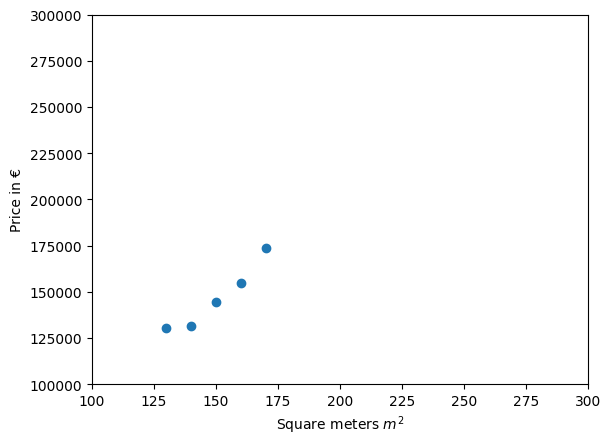

In [3]:
# Plot the data
plt.xlim(100, 300)
plt.ylim(100000, 300000)
plt.scatter(X, y)
plt.xlabel(r'Square meters $m^2$')
plt.ylabel('Price in €')
plt.show()

First, we begin by training the model. For now, we'll skip the details of how the model was built - don't worry, we'll dive into that a bit later.

In [4]:
# Create the model
deterministic_model = LinearDeterministicModel()
deterministic_model.fit(X, y) # Fit the model to the data
W = deterministic_model.get_params() # Get the parameters of the model
print(W)

[  1086.6213922  -15992.20276523]


After initializing and training the model, the next step is to visualize its performance. We can clearly observe that the model successfully captures the linear relationship within the data. However, it also continues to assume a linear trend for larger houses, particularly those above 250 square meters.

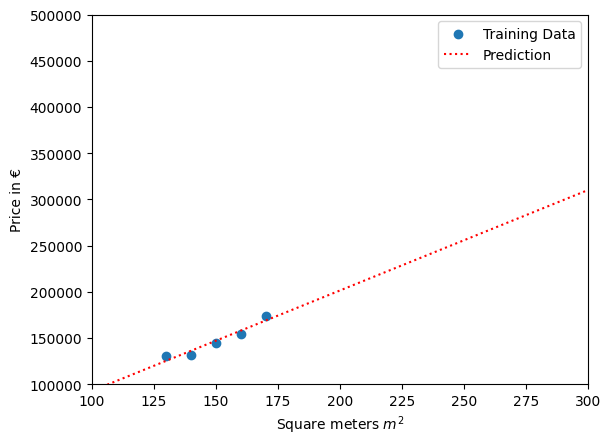

In [5]:
# Plot the prediction line and add legend to the plot
plt.xlim(100, 300)
plt.ylim(100000, 500000)
plt.scatter(X, y, label='Training Data')
plt.plot([100, 300], [W[0]*100 + W[1], W[0]*300 + W[1]], color='red', linestyle='dotted', label='Prediction')
plt.xlabel(r'Square meters $m^2$')
plt.ylabel('Price in €')
plt.legend()
plt.show()

Let’s make predictions on some unseen data points. For a house of $155$ square meters, we can see that the predicted price aligns closely with the actual value, indicating that the model performs well in this range. However, for a house of $280$ square meters, the predicted price starts to deviate from the ground truth. This happens because the $X$ values are far outside the range of our training data, meaning we lack the evidence to support how well the model performs in this region. Our assumption that the relationship remains linear for larger houses may be incorrect, and without additional data, we simply can’t be certain.

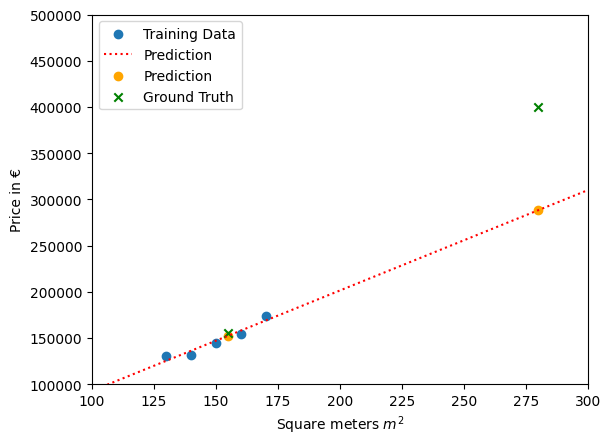

In [6]:
# Predict on new data
X_new = np.array([155, 280])
y_true = np.array([price_per_square_meter * X_new[0], 400_000])
y_pred = deterministic_model.predict(X_new)

# Plot the data
plt.xlim(100, 300)
plt.ylim(100000, 500000)
plt.scatter(X, y, label='Training Data')
plt.plot([100, 300], [W[0]*100 + W[1], W[0]*300 + W[1]], color='red', linestyle='dotted', label='Prediction')
plt.scatter(X_new, y_pred, color='orange', label='Prediction')
plt.scatter(X_new, y_true, color='green', label='Ground Truth', marker='x')
plt.xlabel(r'Square meters $m^2$')
plt.ylabel('Price in €')
plt.legend()
plt.show()

However, in practice we don't know whether the connection remains linear for large values or it grows more rapidly. 
Consider a large mansion on the beach. Because of its location and fancy style it might be way more expensive than the model would assume.

The model is only for good for where we have data. Outside of the range we are not confident.

This is where a probablisitc model comes into play.

In [7]:
prob_model = LinearProbabilisticModel(noise_variance=price_per_square_meter*5)
prob_model.fit(X, y)
params = prob_model.get_params()
pred_mean, pred_std = prob_model.predict(X_new)

# Print prediction results
for i, x in enumerate(X_new):
    print(f'Prediction for {x} m^2: {pred_mean[i]:.2f} € +/- {pred_std[i]:.2f} €')

Prediction for 155 m^2: 152394.59 € +/- 78.22 €
Prediction for 280 m^2: 286875.21 € +/- 286.59 €


With the Probablistic approach, we can see that the confidence interval increase the more we move away from our dataset. For our datapoint at $x=155$ this means that we can be confident that our prediction will be correct. However, for $x=280$ we have large confidence bounde, meaning we cant be certain on a narrow region which is why we have to increase the area for our confidence. A probablistic model helps understand where our strengs and weaknesses are.

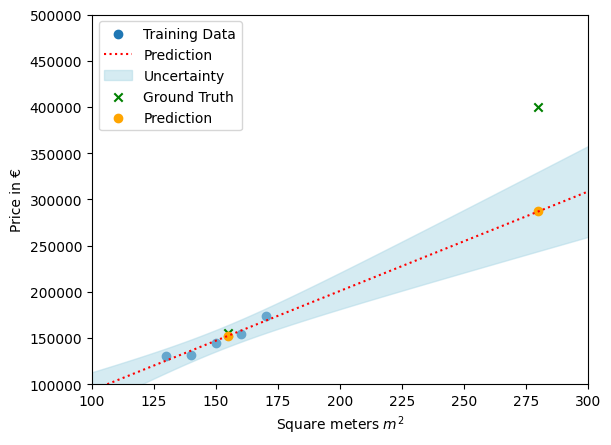

In [8]:
# Create confidence bands
X_continuous = np.linspace(100, 300, 100)
cont_mean, cont_std = prob_model.predict(X_continuous)
cont_std = 150 * cont_std  # Scale the standard deviation for better visualization

# Plot the data and visualize the prediction including the uncertainty
plt.xlim(100, 300)
plt.ylim(100000, 500000)
plt.scatter(X, y, label='Training Data')
plt.plot([100, 300], [params['posterior_mean'][0]*100 + params['posterior_mean'][1], params['posterior_mean'][0]*300 + params['posterior_mean'][1]], color='red', linestyle='dotted', label='Prediction')
plt.fill_between(X_continuous, cont_mean - cont_std, cont_mean + cont_std, color='lightblue', alpha=0.5, label='Uncertainty')
plt.scatter(X_new, y_true, color='green', label='Ground Truth', marker='x')
plt.scatter(X_new, pred_mean, color='orange', label='Prediction')
plt.xlabel(r'Square meters $m^2$')
plt.ylabel('Price in €')
plt.legend()
plt.show()

*IMPORTANT*: A probablistic model is not per se better than a deterministic one. As you can see our second prediction is still off. However, we know this and take this knowledge as a prior in consideriation for future decisions.

In this post, we introduced the basics of Probabilistic Machine Learning (PML) and its importance in handling uncertainty. We compared deterministic models, which provide fixed outputs, with probabilistic models that offer a range of outcomes and capture our confidence in predictions. Through the house price example, we saw how probabilistic models help manage uncertainty, especially when working with noisy or unseen data. In the upcoming posts, we’ll explore probability theory and Gaussian distributions, setting the foundation for more advanced models like VAEs, GANs, and Diffusion Models.

**Stay tuned for more!**